('Days back :%d', 30)


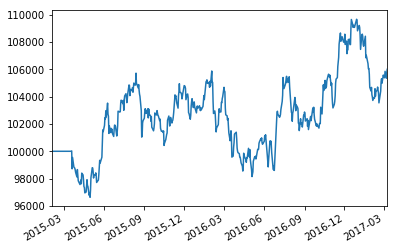

('Days back :%d', 35)


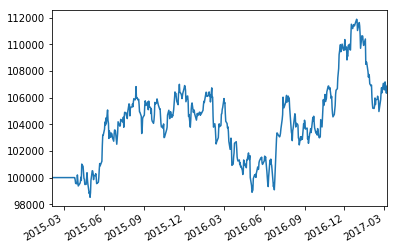

('Days back :%d', 40)


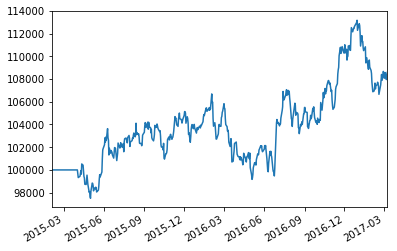

('Days back :%d', 45)


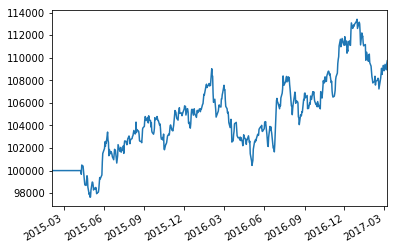

('Days back :%d', 50)


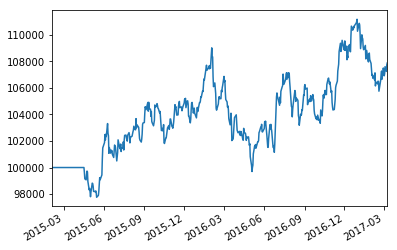

In [4]:
import os
import glob
import pandas as pd
import zipline
from zipline.api import order_target, record, symbol, history
import numpy as np
import matplotlib.pyplot as plt
import portfolioopt as pfopt
import logging as log
from datetime import datetime
import pandas_datareader.data as web
log.basicConfig(filename='log.log',level=log.INFO)

DAYS_BACK = 10    # 30 days for stocks
#STOCKS = [symbol('AUDCAD1440'),symbol('CADJPY1440'),symbol('EURUSD1440'),symbol('AUDUSD1440'),symbol('CADCHF1440'),symbol('GBPUSD1440'),symbol('EURGBP1440')]
inst=['GBP=X','AUD=X','CHF=X','EUR=X','JPY=X','NZD=X']

def optimal_portfolio(returns):   
    avg_rets = returns.mean()    
    cov_mat = returns.cov()
    target_ret = avg_rets.quantile(0.65)
    weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret, allow_short=True)   
    return weights


def initialize(context):
    context.i = 0   
    context.stocks = [symbol('GBP=X'),symbol('AUD=X'),symbol('CHF=X'),symbol('EUR=X'),symbol('JPY=X'),symbol('NZD=X')]
    zipline.api.set_slippage(zipline.api.slippage.FixedSlippage(spread=0.0))   
    zipline.api.set_commission(zipline.api.commission.PerShare(cost=0.0, min_trade_cost=0.0))
    
def handle_data(context, data):
    log.info("handle_data %d",context.i)
    # Skip first 300 days to get full windows
    context.i += 1
    if (context.i < DAYS_BACK):
        return
    
    prices = data.history(context.stocks, 'close', DAYS_BACK, '1d')    
    returns = prices.pct_change().dropna()
    #returns.to_csv('/home/ian/work/python/barchart-data/zprices'+str(context.i)+'.csv',header=True)
    
    try:
        # Perform Markowitz-style portfolio optimization
        weights = optimal_portfolio(returns)
        # Rebalance portfolio accordingly
        for stock in weights.keys():            
            zipline.api.order_target_percent(stock, weights[stock])
            log.info("Stock:%s W:%f",stock,weights[stock])
#        record(AAPL=weights.T[0][0])
#        record(MSFT=weights.T[0][1])
#        record(GOLD=weights.T[0][2])
#        record(AAPL=weights.T[0][0])
#        record(CADJPY=weights.T[0][1])
#        record(EURUSD=weights.T[0][2])
#        record(MSFT=weights.T[0][1])
#        record(SPY=weights.T[0][2])
#        record(CADCHF=weights.T[0][4])
#        record(GBPUSD=weights.T[0][5])
#        record(EURGBP=weights.T[0][6])
        
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass
    

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    
    plt.legend(loc=0)
    plt.show()

ls_key = 'Adj Close'
start = datetime(2015,2,1)
end = datetime(2017,3,8)    
#f = web.DataReader(stocks, 'fred',start,end) -- get FX rates from FRED!
f = web.DataReader(inst, 'yahoo', start, end)
data=pd.DataFrame( f.ix[ls_key] )
    
for DB in [30,35,40,45,50]:
    DAYS_BACK = DB
    algo_obj = zipline.TradingAlgorithm(initialize=initialize, 
                            handle_data=handle_data, data_frequency = 'daily')
    print("Days back :%d",DB)
    results = algo_obj.run(data)
    results.portfolio_value.plot()
    plt.show()